In [1]:
 
import numpy as np
#x,y是平面坐标系,z是手腕坐标系
joints_3d = np.array([[24.25473, 14.594984, -220.86395],
                      [21.384483, 2.5870495, -102.83917],
                      [2.1389189, 0.4295807, -77.805786],
                      [0.4713831, 4.49901, -45.992554],
                      [24.65406, 7.517185, -131.60638],
                      [20.059254, 10.334126, -121.49127],
                      [14.004571, 31.53947, -106.92682],
                      [0.97307205, 54.702316, -72.0885],
                      [34.38083, 5.5681667, -132.75537],
                      [36.56296, 15.5307255, -122.979614],
                      [34.097603, 38.7413, -104.22839],
                      [23.116486, 59.41091, -62.15027],
                      [40.734467, 13.705656, -126.29144],
                      [48.140816, 5.673216, -115.56366],
                      [52.453285, 28.091465, -97.55463],
                      [41.134747, 46.38981, -56.097656],
                      [38.43096, 12.890821, -117.34686],
                      [44.426872, 1.405302, -101.77527],
                      [50.584797, 10.186543, -84.22754],
                      [255, 255, 51.59436],
                      [0., 0., 0.]], dtype=np.float32)
 
joints_3d_visible = np.array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]], dtype=np.float32)
 
img_size = [256, 256]
W, H, D = 64, 64, 64
num_joints = 21
mu_x = joints_3d[:, 0] * W / img_size[0]
mu_y = joints_3d[:, 1] * H / img_size[1]
 
print('==mu_x:', mu_x)
print('==mu_y:', mu_y)
 
target = np.zeros([num_joints, H, W], dtype=np.float32)
 
target_weight = joints_3d_visible[:, 0].astype(np.float32)
# print('==target_weight:', target_weight)
target_weight = target_weight * (mu_x >= 0) * (mu_x < W) * (mu_y >= 0) * (mu_y < H)
 
target_weight = target_weight[:, None]
sigma = 2.5
# only compute the voxel value near the joints location
tmp_size = 3 * sigma
 
# get neighboring voxels coordinates
x = y = np.arange(2 * tmp_size + 1, dtype=np.float32) - tmp_size
yy, xx = np.meshgrid(y, x)
 
xx = xx[None, ...].astype(np.float32)  # (1, 2 * tmp_size + 1, 2 * tmp_size + 1,2 * tmp_size + 1, 2 * tmp_size + 1)
yy = yy[None, ...].astype(np.float32)
 
mu_x = mu_x[..., None, None]  # (21, 1, 1)
mu_y = mu_y[..., None, None]
xx, yy = xx + mu_x, yy + mu_y  # (42, 2 * tmp_size + 1, 2 * tmp_size + 1, 2 * tmp_size + 1)
print('==np.min(xx):', np.min(xx))
print('==np.max(xx):', np.max(xx))
# round the coordinates
xx = xx.round().clip(0, W - 1)
yy = yy.round().clip(0, H - 1)
 
# compute the target value near joints
local_target = np.exp(-((xx - mu_x) ** 2 + (yy - mu_y) ** 2) / (2 * sigma ** 2))
print('==local_target.shape:', local_target.shape)
print('==np.max(local_target):', np.max(local_target))
# import pdb;pdb.set_trace()
# put the local target value to the full target heatmap
local_size = xx.shape[1]
idx_joints = np.tile(
    np.arange(num_joints)[:, None, None],
    [1, local_size, local_size])
print('==idx_joints.shape:', idx_joints.shape)
# print("===np.stack([idx_joints, zz, yy, xx],axis=-1)", np.stack([idx_joints, zz, yy, xx], axis=-1).shape)
idx = np.stack([idx_joints, yy, xx], axis=-1).astype(np.long).reshape(-1, 3)
 
target[idx[:, 0], idx[:, 1], idx[:, 2]] = local_target.reshape(-1)
for i in range(num_joints):
    idx = np.unravel_index(np.argmax(target[i], axis=None), target[i].shape)
    print('===i, idx:', i, idx)
print(np.max(target))
print(np.min(target))

==mu_x: [ 6.0636826   5.346121    0.5347297   0.11784577  6.163515    5.0148134
  3.5011427   0.24326801  8.595207    9.14074     8.524401    5.7791214
 10.183617   12.035204   13.113321   10.283687    9.60774    11.106718
 12.646199   63.75        0.        ]
==mu_y: [ 3.648746    0.6467624   0.10739517  1.1247525   1.8792963   2.5835316
  7.8848677  13.675579    1.3920417   3.8826814   9.685325   14.852728
  3.426414    1.418304    7.0228662  11.597452    3.2227054   0.3513255
  2.5466359  63.75        0.        ]
==np.min(xx): -7.5
==np.max(xx): 71.25
==local_target.shape: (21, 16, 16)
==np.max(local_target): 1.0
==idx_joints.shape: (21, 16, 16)
===i, idx: 0 (4, 6)
===i, idx: 1 (1, 5)
===i, idx: 2 (0, 1)
===i, idx: 3 (1, 0)
===i, idx: 4 (2, 6)
===i, idx: 5 (3, 5)
===i, idx: 6 (8, 4)
===i, idx: 7 (14, 0)
===i, idx: 8 (1, 9)
===i, idx: 9 (4, 9)
===i, idx: 10 (10, 9)
===i, idx: 11 (15, 6)
===i, idx: 12 (3, 10)
===i, idx: 13 (1, 12)
===i, idx: 14 (7, 13)
===i, idx: 15 (12, 10)
===i, idx

<ipython-input-1-eb2e7c08c33c>:95: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.stack([idx_joints, yy, xx], axis=-1).astype(np.long).reshape(-1, 3)


http://muyaan.com/2018/10/25/%E7%94%9F%E6%88%90%E4%BA%8C%E7%BB%B4%E9%AB%98%E6%96%AF%E5%88%86%E5%B8%83%E7%83%AD%E5%8A%9B%E5%9B%BE/

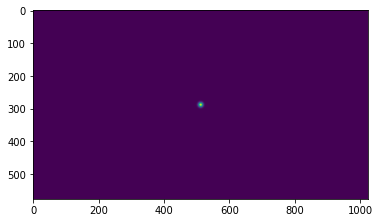

In [4]:
%matplotlib inline
import numpy as np
from math import exp, log, sqrt, ceil
from matplotlib import pyplot as plt

def cal_sigma(dmax, edge_value):
    """Calculate a sigma makes those point's distance to 
    center is dmax value equal to edge value"""
    return sqrt(- pow(dmax, 2) / log(edge_value))

def gaussian(dx, dy, sigma):
    """modifyed version normal distribution pdf"""
    x_term = pow(dx, 2)
    y_term = pow(dy, 2)
    exp_value = - (x_term + y_term) / 2 / pow(sigma, 2)
    return exp(exp_value)

def draw_heatmap(width, height, dmax, x, y, sigma, edge_value):
    heatmap = np.zeros((height, width), dtype=np.float32)
    r = sqrt(2 * pow(dmax, 2))
    intr = int(1.9*dmax)
    xmin = max(0, x - intr)
    xmax = min(width - 1, x + intr)
    ymin = max(0, y - intr)
    ymax = min(height - 1, y + intr)
    for i in range(xmin, xmax):
        for j in range(ymin, ymax):
            dx = x - i
            dy = y - j
            dist = sqrt(pow(dx, 2) + pow(dy, 2))
            if dist > intr:
                continue
            value = gaussian(x - i, y - j, sigma)
            heatmap[j, i] = value
    return heatmap
    
def test():
    dmax = 100
    edge_value = 0.01
    sigma = cal_sigma(dmax, edge_value)
    hm = draw_heatmap(1024, 576, dmax, 512, 288, sigma, edge_value)
    return hm
    
# %timeit hm = test()
hm = test()
plt.imshow(hm)
plt.show()

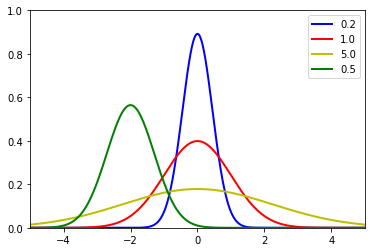

In [1]:
#                    Normal Distribution
import numpy as np
import matplotlib.pyplot as plt 

def make_gauss(N, sig, mu):
    return lambda x: N/(sig * (2*np.pi)**.5) * np.e ** (-(x-mu)**2/(2 * sig**2))

def main():
    ax = plt.figure().add_subplot(1,1,1)
    x = np.arange(-5, 5, 0.01)
    s = np.sqrt([0.2, 1, 5, 0.5])
    m = [0, 0, 0, -2] 
    c = ['b','r','y','g']

    for sig, mu, color in zip(s, m, c): 
        gauss = make_gauss(1, sig, mu)(x)
        ax.plot(x, gauss, color, linewidth=2)

    plt.xlim(-5, 5)
    plt.ylim(0, 1)
    plt.legend(['0.2', '1.0', '5.0', '0.5'], loc='best')
    plt.show()

if __name__ == '__main__':
   main()

In [6]:
import numpy as np
from itertools import product
from matplotlib import pyplot as plt
def gaussianHeatmap(sigma, dim: int = 2, nsigma: int = 3):
    if nsigma <= 2:
        print('[Warning]: nsigma={} is recommended to be greater than 2'.format(nsigma))
    radius = round(nsigma*sigma)
    center = tuple([radius for i in range(dim)])
    mask_shape = tuple([2*radius for i in range(dim)])
    mask = np.zeros(mask_shape, dtype=np.float)
    sig2 = sigma**2
    coef = sigma*np.sqrt(2*np.pi)
    for p in product(*[range(i) for i in mask_shape]):
        d2 = sum((i-j)**2 for i, j in zip(center, p))
        mask[p] = np.exp(-d2/sig2/2)/coef
    mask = (mask-mask.min())/(mask.max()-mask.min()) # necessary?, yes, the output heatmap is processed with sigmoid

    def genHeatmap(point, shape):
        ret = np.zeros(shape, dtype=np.float)
        bboxs = [(max(0, point[ax]-radius), min(shape[ax], point[ax]+radius))
                 for ax in range(dim)]
        img_sls = tuple([slice(i, j) for i, j in bboxs])
        mask_begins = [max(0, radius-point[ax]) for ax in range(dim)]
        mask_sls = tuple([slice(beg, beg+j-i)
                          for beg, (i, j) in zip(mask_begins, bboxs)])
        ret[img_sls] = mask[mask_sls]
        return ret
    return genHeatmap

C:\Users\Bxd\AppData\Local\Temp\ipykernel_34820\3539308231.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(mask_shape, dtype=np.float)


TypeError: Image data of dtype object cannot be converted to float

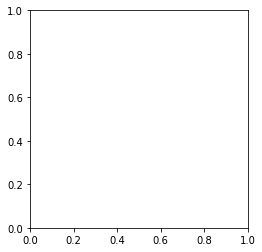

In [12]:
dim = 2
heatmap = gaussianHeatmap(sigma = 10,dim = dim)
plt.imshow(heatmap)
plt.show()

(18, 18)
[[1.64111296e-05 4.21993231e-05 9.70996251e-05 1.99928487e-04
  3.68363730e-04 6.07329117e-04 8.96017314e-04 1.18291560e-03
  1.39744966e-03 1.47728280e-03 1.39744966e-03 1.18291560e-03
  8.96017314e-04 6.07329117e-04 3.68363730e-04 1.99928487e-04
  9.70996251e-05 4.21993231e-05]
 [4.21993231e-05 1.08510683e-04 2.49680464e-04 5.14092999e-04
  9.47204762e-04 1.56167664e-03 2.30400497e-03 3.04173075e-03
  3.59338030e-03 3.79866201e-03 3.59338030e-03 3.04173075e-03
  2.30400497e-03 1.56167664e-03 9.47204762e-04 5.14092999e-04
  2.49680464e-04 1.08510683e-04]
 [9.70996251e-05 2.49680464e-04 5.74508729e-04 1.18291560e-03
  2.17949532e-03 3.59338030e-03 5.30145990e-03 6.99894912e-03
  8.26828143e-03 8.74062970e-03 8.26828143e-03 6.99894912e-03
  5.30145990e-03 3.59338030e-03 2.17949532e-03 1.18291560e-03
  5.74508729e-04 2.49680464e-04]
 [1.99928487e-04 5.14092999e-04 1.18291560e-03 2.43562758e-03
  4.48758892e-03 7.39878330e-03 1.09157255e-02 1.44108621e-02
  1.70244220e-02 1.79969

C:\Users\Bxd\AppData\Local\Temp\ipykernel_34820\536561814.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(mask_shape, dtype=np.float)


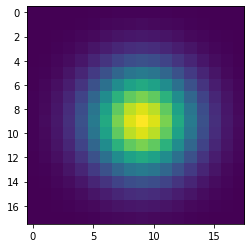

In [18]:
sigma = 3
nsigma = 3
radius = 9
center = (9,9)
mask_shape = (tuple([2*radius for i in range(dim)]))
mask = np.zeros(mask_shape, dtype=np.float)
sig2 = sigma**2
coef = sigma*np.sqrt(2*np.pi)
for p in product(*[range(i) for i in mask_shape]):
    d2 = sum((i-j)**2 for i, j in zip(center, p))
    mask[p] = np.exp(-d2/sig2/2)/coef
    #mask = (mask-mask.min())/(mask.max()-mask.min()) # necessary?, yes, the output heatmap is processed with sigmoid
print(mask_shape)
print(mask)
plt.imshow(mask)
plt.show()

(slice(102, 120, None), slice(481, 499, None))


C:\Users\Bxd\AppData\Local\Temp\ipykernel_34820\296005416.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ret = np.zeros(shape, dtype=np.float)


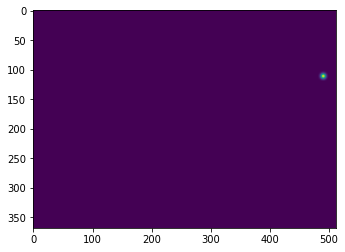

In [21]:
point = (111,490)
shape = [368,512]
ret = np.zeros(shape, dtype=np.float)
bboxs = [(102, 120), (481, 499)]
img_sls = tuple([slice(i, j) for i, j in bboxs])
print(img_sls)
mask_begins = [max(0, radius-point[ax]) for ax in range(dim)]
print(mask_begins)
mask_sls = tuple([slice(beg, beg+j-i)
                for beg, (i, j) in zip(mask_begins, bboxs)])
print(mask_sls)                      
ret[img_sls] = mask[mask_sls]

plt.imshow(ret)
plt.show()